# Advanced Challenge + Challenge Expansion

We create our own 6-qubit LiH ansatz with the Bravyi-Kitaev mapper, and run it on real hardware along with simulators to compare performances of our VQE algorithm in finding the ground state energy. 

In [1]:
#Pytket imports
from pytket import Circuit, Qubit
from pytket.circuit.display import render_circuit_jupyter
from pytket.extensions.qiskit import AerBackend
from pytket.extensions.qiskit import qiskit_to_tk, tk_to_qiskit
from pytket.qasm import circuit_to_qasm, circuit_from_qasm
from pytket.circuit import OpType

#Optimization imports
from pytket.passes import *
from pytket.predicates import CompilationUnit
from pytket.transform import CXConfigType

#For running on IBM Quantum Chips
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
import qiskit.providers.aer.noise as noise

#Driver and mapper imports
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import (ElectronicStructureDriverType, 
                                                       ElectronicStructureMoleculeDriver,
                                                       PySCFDriver)
from qiskit_nature.mappers.second_quantization import BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer

#Solver imports
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.algorithms import VQE
from qiskit_nature.algorithms import VQEUCCFactory, GroundStateEigensolver
from qiskit.utils import QuantumInstance
from qiskit.circuit.library import TwoLocal
import pyscf


#Load IBM account to ensure access to chips
IBMQ.save_account('') # Save TOKEN to disk
IBMQ.load_account() # Load account from disk
IBMQ.providers()    # List all available providers
provider = IBMQ.load_account()

#For graphing and basic math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import pi
import numpy as np

#Sanity check
backend = AerBackend()
backend.required_predicates

configrc.store_credentials:WARNING:2022-08-23 17:10:45,147: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-08-23 17:10:48,371: Credentials are already in use. The existing account in the session will be replaced.


[NoSymbolsPredicate,
 GateSetPredicate:{ SX Y ZZPhase RangePredicate X YYPhase Z XXPhase S Sdg T Tdg SXdg CnX Barrier CCX H Rx Unitary1qBox Ry Unitary2qBox Rz U3 U2 U1 TK1 CX CY CZ CU1 CU3 SWAP CSWAP noop Measure Reset PhasedX }]

In [2]:
#Establish some variables and shortcuts for classes to create the molecule and set up a VQE solver
molecule = Molecule(geometry=[['Li', [0.0, 0.0, 0.0]], ['H', [0.0, 0.0, 1.5474]]])

driver = ElectronicStructureMoleculeDriver(molecule, driver_type = ElectronicStructureDriverType.PYSCF)

In [3]:
es_problem = ElectronicStructureProblem(driver, transformers = 
                                                    [FreezeCoreTransformer(freeze_core = True, 
                                                                           remove_orbitals = [3,4])])
second_q_op = es_problem.second_q_ops()
print(second_q_op[0])

Fermionic Operator
register length=6, number terms=342
  -0.7806641144801505 * ( +_0 -_0 )
+ 0.04770212338477363 * ( +_0 -_1 )
+ -0.12958118897497894 * ( +_0 -_2 )
+ 0.0477021233847736 * ( +_1 -_0 )
+ -0.35909729348090397 * ( +_1 -_1 )
+ 0.06823802789 ...


/Users/administrator/opt/anaconda3/envs/tket/lib/python3.9/site-packages/qiskit_nature/problems/second_quantization/electronic/electronic_structure_problem.py:93: ListAuxOpsDeprecationWarning: List-based `aux_operators` are deprecated as of version 0.3.0 and support for them will be removed no sooner than 3 months after the release. Instead, use dict-based `aux_operators`. You can switch to the dict-based interface immediately, by setting `qiskit_nature.settings.dict_aux_operators` to `True`.
  second_quantized_ops = self._grouped_property_transformed.second_q_ops()


### Ground State Solvers and FermionicOp Mappers

Here, we specify the electronic structure of the LiH molecule and use the Bravyi-Kitaev Mapper as detailed [here](https://pubs.acs.org/doi/pdf/10.1021/acs.jctc.8b00450). It has been shown that the Bravyi-Kitaev mapping scheme requires fewer quantum gates for simulation of many molecules, including LiH, when compared to the Jordan-Wigner and the Bravyi-Kitaev Super Fast schemes. However, the Jordan-Wigner method does generally have a [sparser entanglement map](https://journals.aps.org/prxquantum/pdf/10.1103/PRXQuantum.2.020337), so it is expected that the mapping used here will still generate noise when run on a real device.

In [4]:
qubit_converter = QubitConverter(BravyiKitaevMapper(), two_qubit_reduction = True, z2symmetry_reduction = [1,1])

In [51]:
#Convert to QubitOp
qubit_op = qubit_converter.convert(second_q_op[0])
print('Number of qubits: ' + str(qubit_op.num_qubits))

Number of qubits: 4


We will use the Unitary Coupled Cluster (UCC) standard for making our ansatz and then use the ground state eigensolver to calculate ground state energies using Qiskit Aer's simulators. 

In [6]:
#Define solver
numpy_solver = NumPyMinimumEigensolver()
quantum_instance = QuantumInstance(backend=Aer.get_backend("aer_simulator_statevector"))
vqe_solver = VQEUCCFactory(quantum_instance=quantum_instance)

In [7]:
#Create circuit
tl_circuit = TwoLocal(
    rotation_blocks=["ry", "rz"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
    parameter_prefix="y",
    skip_final_rotation_layer = False
)

In [24]:
#Calculate ground state energy
calc = GroundStateEigensolver(qubit_converter, vqe_solver)
res = calc.solve(es_problem)

print(res)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.783386305406
  - computed part:      -0.964696009825
  - FreezeCoreTransformer extracted energy part: -7.818690295581
~ Nuclear repulsion energy (Hartree): 1.025934879643
> Total ground state energy (Hartree): -7.757451425763
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 1.000 S^2: 2.000 M: 1.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  2.92416221]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.04926703]
    - computed part:      [0.0  0.0  1.05321389]
    - FreezeCoreTransformer extracted energy part: [0.0  0.0  -0.00394686]
  > Dipole moment (a.u.): [0.0  0.0  1.87489518]  Total: 1.87489518
                 (debye): [0.0  0.0  4.76550776]  Total: 4.76550776
 


In [9]:
#Compare to known estimates
calc = GroundStateEigensolver(qubit_converter, numpy_solver)
res = calc.solve(es_problem)
print(res)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.789053776487
  - computed part:      -0.970363480906
  - FreezeCoreTransformer extracted energy part: -7.818690295581
~ Nuclear repulsion energy (Hartree): 1.025934879643
> Total ground state energy (Hartree): -7.763118896843
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 1.000 S^2: 2.000 M: -0.985
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  2.92416221]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.33234748]
    - computed part:      [0.0  0.0  1.33629434]
    - FreezeCoreTransformer extracted energy part: [0.0  0.0  -0.00394686]
  > Dipole moment (a.u.): [0.0  0.0  1.59181473]  Total: 1.59181473
                 (debye): [0.0  0.0  4.04598909]  Total: 4.04598909
 


### Results with simulators

When run on Qiskit Aer's simulator with Qiskit's circuit optimization, the ground state energy calculation is off by 0.064\%. The values calculated are very similar to results found from [classical calculations](https://indico.in2p3.fr/event/2481/contributions/24469/contribution.pdf), so results were as expected. We will now compare these values to the ones obtained by real devices.

### Running tests on real devices 

We first begin with `ibmq_belem`, where we run into some issues since there are many circuits that need to be compiled in order to minimize guesses and return an eigen value for our ansatz. An earlier run that worked in returning a completed job failed to publish a resulting ground state energy, so we will now use a noise model run on a simulator based on `ibmq_belem` to analyze results. 

In [29]:
#Set up noise model based on ibmq_belem specs that can be tuned later
from qiskit.providers.aer.noise import NoiseModel

device = provider.get_backend('ibmq_belem')
noise_model = NoiseModel.from_backend(device)

basis_gates = device.configuration().basis_gates
coupling_map = device.configuration().coupling_map

#Noisy solver
another_solver = VQE(
    ansatz=tl_circuit,
    quantum_instance=QuantumInstance(Aer.get_backend("aer_simulator_statevector"), 
                                     coupling_map=coupling_map, noise_model = noise_model),
)

#Caluclate ground state energy
calc = GroundStateEigensolver(qubit_converter, another_solver)
res = calc.solve(es_problem)

print(res)

### Optimizing our ansatz

Due to long queue times (estimated wait times are currently at a minimum of 9 hours), we will only use `ibmq_belem`, but these calculations can be further used to compare which devices return the closest result. We will instead continue with the transpiled circuit provided by running the ground state eigensolver on `ibmq_belem`.

In [52]:
#Import the ansatz as a QASM file provided from the above job's result
qasmfile = "belem_job1.qasm"
qc = circuit_from_qasm(qasmfile) #generates circuit

In [53]:
print("TKET circuit depth reading: " + str(qc.depth())) 

TKET circuit depth reading: 446


In [54]:
#Some basic optimization using just passes
seqpass = SequencePass([CommuteThroughMultis(), RemoveRedundancies(), 
                        SimplifyInitial(), KAKDecomposition(), RemoveDiscarded(),
                        ZZPhaseToRz()])
reppass = RepeatPass(seqpass)
cu = CompilationUnit(qc)
reppass.apply(cu)
qc1 = cu.circuit

#Check to see how it affected the circuit depth
print("New TKET circuit depth reading: " + str(qc1.depth())) 

New TKET circuit depth reading: 26


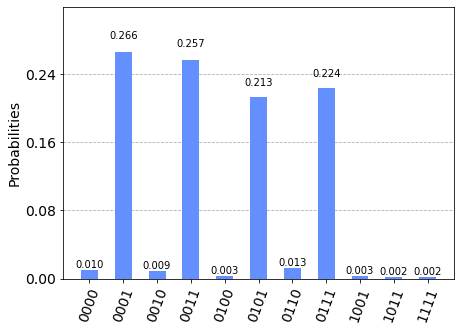

In [56]:
circ = tk_to_qiskit(qc1)

real_device = provider.get_backend('ibmq_belem') 
basis_gates = real_device.configuration().basis_gates

#Send job to belem
job = execute(circ, real_device, basis_gates=basis_gates, shots=1024)
result = job.result() #execute circuit defined previously
belem_counts = result.get_counts()
plot_histogram(belem_counts)

In [92]:
qubit_op = circ
print('Number of qubits: ' + str(qubit_op.num_qubits))

Number of qubits: 5


In [93]:
print(qubit_op)

global phase: π/4
          ┌───┐      ┌────┐           ┌─────────┐          »
  q_0: ───┤ X ├──────┤ √X ├───────────┤ Rz(π/2) ├──────────»
       ┌──┴───┴──┐   ├────┤           ├─────────┤          »
  q_1: ┤ Rz(π/2) ├───┤ √X ├───────────┤ Rz(π/2) ├──────────»
       └──┬────┬─┘┌──┴────┴─┐         └──┬────┬─┘          »
  q_2: ───┤ √X ├──┤ Rz(π/2) ├────────────┤ √X ├────────────»
          ├────┤  ├─────────┤┌───────────┴────┴───────────┐»
  q_3: ───┤ √X ├──┤ Rz(π/2) ├┤ U(π/2,π/2 - π/2,π/2 + π/2) ├»
          └────┘  └─────────┘└────────────────────────────┘»
  q_4: ────────────────────────────────────────────────────»
                                                           »
c74: 4/════════════════════════════════════════════════════»
                                                           »
«       ┌──────────────────────────────┐            ┌────┐            »
«  q_0: ┤ U(7π/2,π/2 - π/2,π/2 + 7π/2) ├────────────┤ √X ├────────────»
«       └─────┬──────────────────┬─────┘┌────

Borrowing an idle qubit remover from [here](https://quantumcomputing.stackexchange.com/questions/25672/remove-inactive-qubits-from-qiskit-circuit).

In [108]:
from qiskit.converters import circuit_to_dag, dag_to_circuit
from collections import OrderedDict
from qiskit import QuantumCircuit

circ.remove_final_measurements()

def remove_idle_qwires(circ):
    dag = circuit_to_dag(circ)
    idle_wires = list(dag.idle_wires())
    for w in idle_wires:
        dag._remove_idle_wire(w)
        dag.qubits.remove(w)
    dag.qregs = OrderedDict()
    return dag_to_circuit(dag)

In [110]:
circ2 = remove_idle_qwires(circ)

In [111]:
print(circ2)

global phase: π/4
      ┌───┐      ┌────┐           ┌─────────┐          »
0: ───┤ X ├──────┤ √X ├───────────┤ Rz(π/2) ├──────────»
   ┌──┴───┴──┐   ├────┤           ├─────────┤          »
1: ┤ Rz(π/2) ├───┤ √X ├───────────┤ Rz(π/2) ├──────────»
   └──┬────┬─┘┌──┴────┴─┐         └──┬────┬─┘          »
2: ───┤ √X ├──┤ Rz(π/2) ├────────────┤ √X ├────────────»
      ├────┤  ├─────────┤┌───────────┴────┴───────────┐»
3: ───┤ √X ├──┤ Rz(π/2) ├┤ U(π/2,π/2 - π/2,π/2 + π/2) ├»
      └────┘  └─────────┘└────────────────────────────┘»
«   ┌──────────────────────────────┐            ┌────┐            ┌──────────┐»
«0: ┤ U(7π/2,π/2 - π/2,π/2 + 7π/2) ├────────────┤ √X ├────────────┤ Rz(7π/2) ├»
«   └─────┬──────────────────┬─────┘┌───────────┴────┴───────────┐└┬────────┬┘»
«1: ──────┤ U(7π/2,-π/2,π/2) ├──────┤ U(7π/2,π - π/2,π/2 + 7π/2) ├─┤ Rz(3π) ├─»
«         └────┬────────┬────┘      └───────────┬────┬───────────┘ ├────────┤ »
«2: ───────────┤ Rz(3π) ├───────────────────────┤ √X ├─────────────┤ 

In [114]:
#New qubit operator
qubit_op = circ2

In [115]:
device = provider.get_backend('ibmq_belem')
noise_model = NoiseModel.from_backend(device)
coupling_map = device.configuration().coupling_map
basis_gates = noise_model.basis_gates

print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['reset', 'id', 'measure', 'cx', 'sx', 'x']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (4, 3)), ('cx', (3, 4)), ('cx', (3, 1)), ('cx', (1, 3)), ('cx', (2, 1)), ('cx', (1, 2)), ('cx', (1, 0)), ('cx', (0, 1)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]


In [116]:
seed = 100
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,)

In [117]:
from qiskit.algorithms.optimizers import SPSA 

new_circ = TwoLocal(rotation_blocks=["ry", "rz"],
                        entanglement_blocks="cx",
                        entanglement="linear",
                        reps=1,
                        parameter_prefix="y",
                        skip_final_rotation_layer = False)
spsa = SPSA(maxiter=iterations)
vqe = VQE(new_circ, optimizer=spsa, 
           quantum_instance=qi)

calc = GroundStateEigensolver(qubit_converter, vqe)
res = calc.solve(es_problem)

print(res)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.692331790689
  - computed part:      -0.873641495107
  - FreezeCoreTransformer extracted energy part: -7.818690295581
~ Nuclear repulsion energy (Hartree): 1.025934879643
> Total ground state energy (Hartree): -7.666396911045
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.104 S: 0.963 S^2: 1.891 M: 0.895
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  2.92416221]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.63755921]
    - computed part:      [0.0  0.0  1.64150607]
    - FreezeCoreTransformer extracted energy part: [0.0  0.0  -0.00394686]
  > Dipole moment (a.u.): [0.0  0.0  1.286603]  Total: 1.286603
                 (debye): [0.0  0.0  3.27021832]  Total: 3.27021832
 


Using `tket` to optimize works! The results are still within a very small percentage of the actual answer.

### Considering different mappings

We will now look at how choosing a different mapping affects noise in our system by running these simulations again with the Jordan-Wigner mapping.

In [85]:
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, BravyiKitaevSuperFastMapper

#New mapping
new_qubit_converter = QubitConverter(JordanWignerMapper(), 
                                 two_qubit_reduction = True, z2symmetry_reduction = [1,1])

#Convert to new QubitOp
qubit_op = new_qubit_converter.convert(second_q_op[0])
print('Number of qubits: ' + str(qubit_op.num_qubits))

Number of qubits: 4


In [86]:
device = provider.get_backend('ibmq_belem')
noise_model = NoiseModel.from_backend(device)
coupling_map = device.configuration().coupling_map
basis_gates = noise_model.basis_gates

qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,)

jw_circ = TwoLocal(rotation_blocks=["ry", "rz"],
                        entanglement_blocks="cx",
                        entanglement="linear",
                        reps=1,
                        parameter_prefix="y",
                        skip_final_rotation_layer = False)
spsa = SPSA(maxiter=iterations)
vqe = VQE(jw_circ, optimizer=spsa, 
           quantum_instance=qi)

calc = GroundStateEigensolver(qubit_converter, vqe)
res = calc.solve(es_problem)

print(res)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.710414439077
  - computed part:      -0.891724143496
  - FreezeCoreTransformer extracted energy part: -7.818690295581
~ Nuclear repulsion energy (Hartree): 1.025934879643
> Total ground state energy (Hartree): -7.684479559433
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.008 S: 0.979 S^2: 1.939 M: -0.954
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  2.92416221]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.16205314]
    - computed part:      [0.0  0.0  1.166]
    - FreezeCoreTransformer extracted energy part: [0.0  0.0  -0.00394686]
  > Dipole moment (a.u.): [0.0  0.0  1.76210907]  Total: 1.76210907
                 (debye): [0.0  0.0  4.47883408]  Total: 4.47883408
 


### Using the `BravyiKitaevSuperFastMapper`

This one is considered to introduce more error.

In [119]:
#New mapping
another_qubit_converter = QubitConverter(BravyiKitaevSuperFastMapper(), 
                                 two_qubit_reduction = True, z2symmetry_reduction = [1,1])

#Convert to new QubitOp
qubit_op = qubit_converter.convert(second_q_op[0])
print('Number of qubits: ' + str(qubit_op.num_qubits))

Number of qubits: 4


In [121]:
device = provider.get_backend('ibmq_belem')
noise_model = NoiseModel.from_backend(device)
coupling_map = device.configuration().coupling_map
basis_gates = noise_model.basis_gates

qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,)

bksf_circ = TwoLocal(rotation_blocks=["ry", "rz"],
                        entanglement_blocks="cx",
                        entanglement="linear",
                        reps=1,
                        parameter_prefix="y",
                        skip_final_rotation_layer = False)
spsa = SPSA(maxiter=iterations)
vqe = VQE(bksf_circ, optimizer=spsa, 
           quantum_instance=qi)

calc = GroundStateEigensolver(qubit_converter, vqe)
res = calc.solve(es_problem)

print(res)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.706839437555
  - computed part:      -0.888149141974
  - FreezeCoreTransformer extracted energy part: -7.818690295581
~ Nuclear repulsion energy (Hartree): 1.025934879643
> Total ground state energy (Hartree): -7.680904557912
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.043 S: 0.973 S^2: 1.920 M: -0.944
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  2.92416221]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.40418813]
    - computed part:      [0.0  0.0  1.40813499]
    - FreezeCoreTransformer extracted energy part: [0.0  0.0  -0.00394686]
  > Dipole moment (a.u.): [0.0  0.0  1.51997408]  Total: 1.51997408
                 (debye): [0.0  0.0  3.86338839]  Total: 3.86338839
 


### Summary:

- Ground state energy: -8.789053776487 
- Noiseless simulation with Bravyi-Kitaev Mapping: -8.783386305406
- Simulation after optimizing with `tket`: -8.692331790689
- Simulation with Jordan-Wigner Mapping: -8.710414439077
- Simulation with Bravyi-Kitaev Super Fast Mapping: -8.706839437555

Running multiple optimization passes on an ansatz circuit seems to introduce some extra noise from the information lost. Similarly, the Super Fast Mapping introduces more noise, however (with this small noise model) the results are still very close to the classically computed answer.